In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import ast
import re

# Load data
train_data = pd.read_csv('Training_dataset.csv')

# Explore data
print(train_data.head())
print(train_data.info())
print(train_data.describe())

# Handle missing values
train_data = train_data.dropna(subset=['Dealer_Listing_Price', 'Vehicle_Trim'])

# One-hot Encode on below features
train_data = pd.get_dummies(train_data, columns=['VehFuel', 'VehPriceLabel'])

# Encode categorical variables
categorical_cols = ['SellerCity', 'SellerListSrc', 'VehBodystyle', 'VehDriveTrain', 'VehEngine', 'VehMake', 'VehModel', 'Vehicle_Trim']
encoders = {}

for col in categorical_cols:
    encoders[col] = LabelEncoder()
    train_data[col] = encoders[col].fit_transform(train_data[col])
    
# Convert VehFeats column from string to list
train_data['VehFeats'] = train_data['VehFeats'].replace('nan', np.nan, regex=True)
train_data['VehFeats'] = train_data['VehFeats'].apply(lambda x: [item.strip() for item in ast.literal_eval(str(x))] if not pd.isna(x) else [])

# Count the number of vehicle features
train_data['VehFeats_Count'] = train_data['VehFeats'].apply(len)

# Get vehicle history in the form of number of users
def get_num_users(history):
    if pd.isna(history):
        return 0
    else:
        pattern = r'\b(\d+)\s*Owner[s]?,?'
        match = re.search(pattern, str(history))
        if match:
            num_users = int(match.group(1))
            return num_users
        else:
            return 1  # Default to 1 owner if no pattern match

train_data['VehHistory_NumUsers'] = train_data['VehHistory'].apply(get_num_users)

# Drop useless columns and missing data
drop_columns = ["SellerCity", "VehBodystyle", "VehFeats", "VehHistory", "VehSellerNotes", "VehType", 'SellerName', 'SellerState', 'SellerZip', 'VehColorExt', 'VehTransmission', 'VehColorInt']
train_data = train_data.drop(drop_columns, axis=1)
train_data = train_data.dropna()

train_data.head(5)

   ListingID    SellerCity  SellerIsPriv               SellerListSrc  \
0       3287        Warren         False    Inventory Command Center   
1       3920         Fargo         False  Cadillac Certified Program   
2       4777      Waukesha         False      Jeep Certified Program   
3       6242    Wentzville         False    Inventory Command Center   
4       7108  Fayetteville         False          HomeNet Automotive   

                                   SellerName  SellerRating  SellerRevCnt  \
0                                Prime Motorz           5.0            32   
1                  Gateway Chevrolet Cadillac           4.8          1456   
2  Wilde Chrysler Jeep Dodge Ram &amp; Subaru           4.8          1405   
3             Century Dodge Chrysler Jeep RAM           4.4            21   
4          Superior Buick GMC of Fayetteville           3.7            74   

  SellerState  SellerZip VehBodystyle  ...   VehMake VehMileage  \
0          MI    48091.0          SUV

,ListingID,SellerIsPriv,SellerListSrc,SellerRating,SellerRevCnt,VehCertified,VehDriveTrain,VehEngine,VehListdays,VehMake,...,Dealer_Listing_Price,VehFuel_Diesel,VehFuel_E85 Flex Fuel,VehFuel_Gasoline,VehFuel_Unknown,VehPriceLabel_Fair Price,VehPriceLabel_Good Deal,VehPriceLabel_Great Deal,VehFeats_Count,VehHistory_NumUsers
0,3287,False,2,5.0,32,False,3,17,8.600069,1,...,30990.0,0,0,1,0,1,0,0,8,1
2,4777,False,3,4.8,1405,True,6,70,28.107014,1,...,23249.0,0,0,1,0,0,1,0,8,1
3,6242,False,2,4.4,21,False,1,17,59.816875,1,...,31977.0,0,0,1,0,0,1,0,8,1
4,7108,False,1,3.7,74,False,14,63,98.665301,0,...,33495.0,0,0,1,0,0,1,0,8,1
5,10882,False,0,3.0,51,False,1,19,30.967500,1,...,27900.0,0,0,1,0,0,1,0,8,1


In [2]:
# Extract the LabelEncoder for 'Vehicle_Trim'
vehicle_trim_encoder = encoders['Vehicle_Trim']

# Get the mapping from class to name
class_to_name_mapping = {index: label for index, label in enumerate(vehicle_trim_encoder.classes_)}

# Convert the mapping to a DataFrame for easy viewing and saving
class_to_name_df = pd.DataFrame(list(class_to_name_mapping.items()), columns=['Class', 'Vehicle_Trim_Name'])

# Save the mapping to a CSV file
class_to_name_df.to_csv('vehicle_trim_class_to_name_mapping.csv', index=False)

print(class_to_name_df.head())

   Class         Vehicle_Trim_Name
0      0          75th Anniversary
1      1  75th Anniversary Edition
2      2                  Altitude
3      3                      Base
4      4                       FWD



Selected features by RFE:
['ListingID', 'SellerRevCnt', 'VehDriveTrain', 'VehEngine', 'VehListdays', 'VehMake', 'VehMileage', 'VehModel', 'VehYear', 'VehPriceLabel_Fair Price']


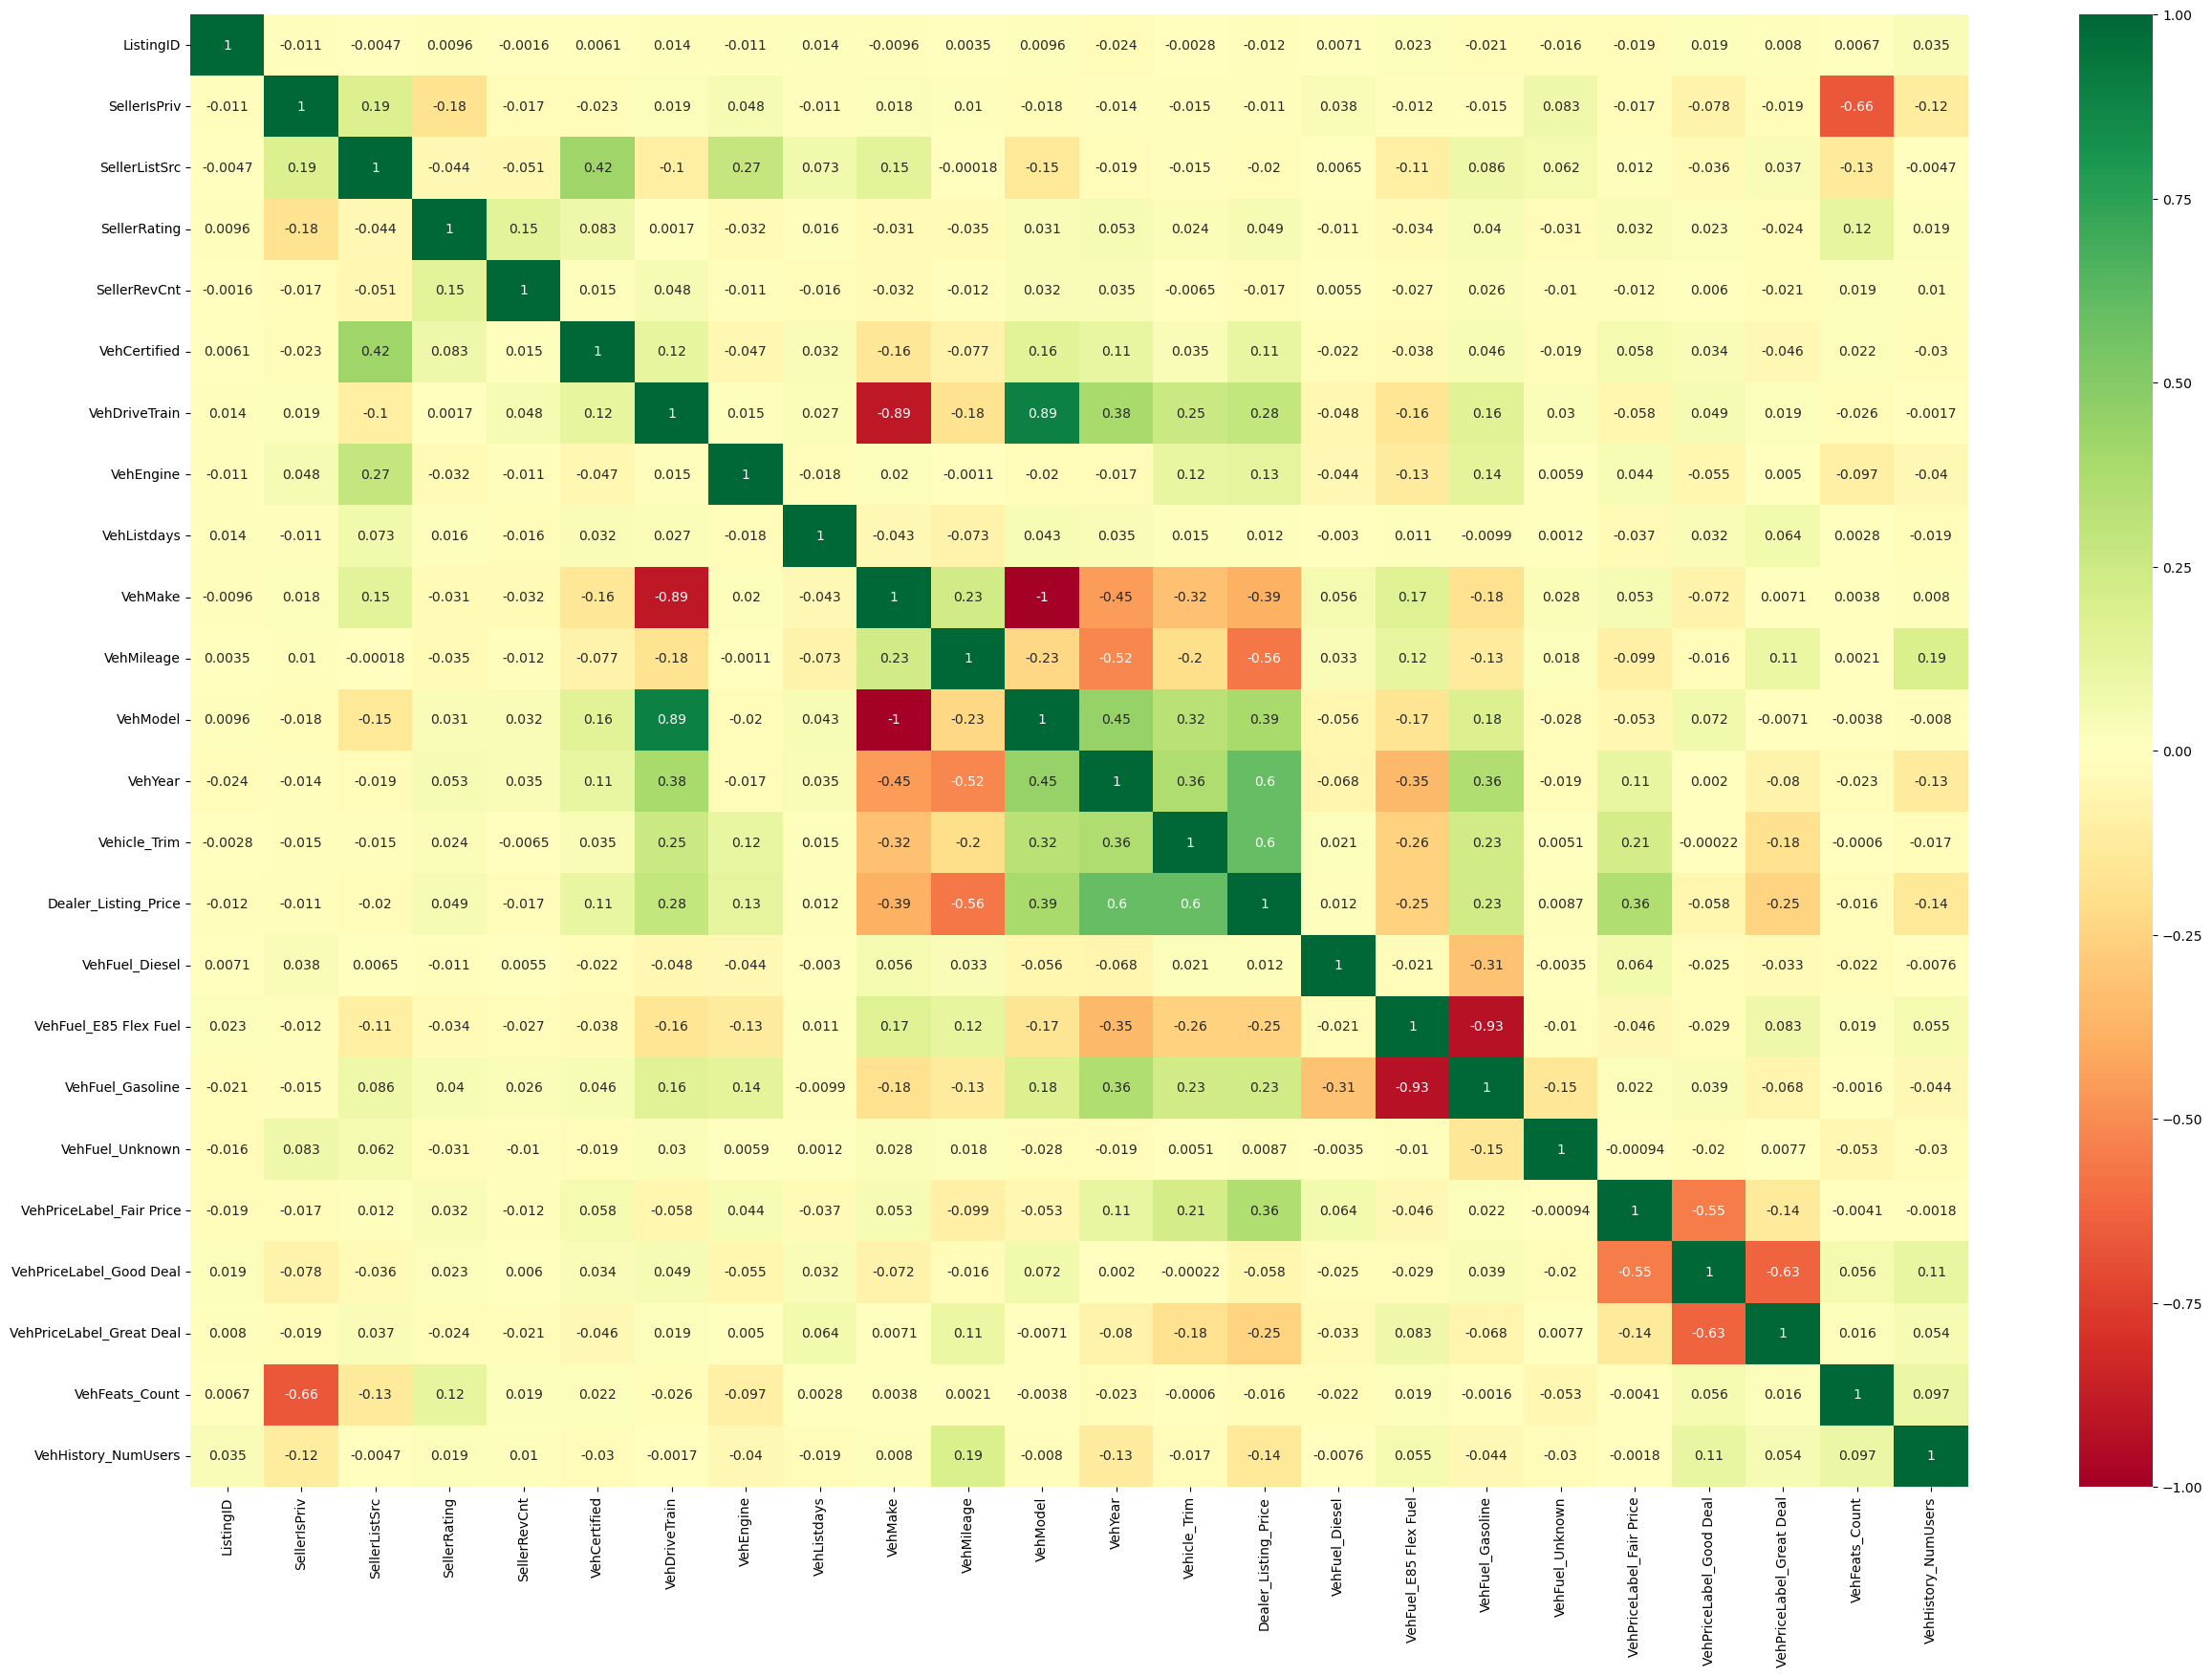

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import Lasso

# Check correlations
plt.figure(figsize=(30, 20))
sns.heatmap(train_data.corr(), annot=True, cmap='RdYlGn')

# Feature selection using Lasso
X = train_data.drop(['Vehicle_Trim', 'Dealer_Listing_Price'], axis=1)
y = train_data['Dealer_Listing_Price']
lasso = Lasso()
model = SelectFromModel(lasso, prefit=False)
X_new = model.fit_transform(X, y)

# Recursive Feature Elimination
from sklearn.ensemble import RandomForestRegressor
rfe = RFE(RandomForestRegressor(), n_features_to_select=10)
X_new = rfe.fit_transform(X, y)

# Getting the final column names selected by RFE
selected_features_rfe = X.columns[rfe.get_support()]

# Displaying the selected features
print("\nSelected features by RFE:")
print(selected_features_rfe.tolist())

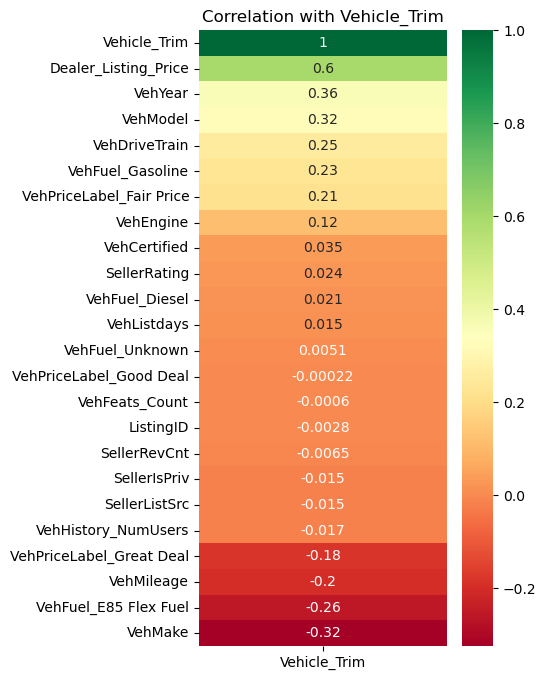

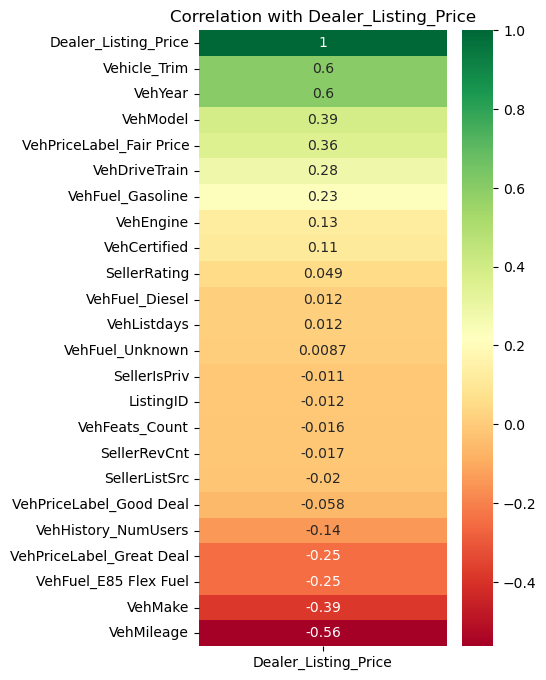

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation with respect to 'Vehicle_Trim'
plt.figure(figsize=(4, 8))
sns.heatmap(train_data.corr()[['Vehicle_Trim']].sort_values(by='Vehicle_Trim', ascending=False), 
            annot=True, cmap='RdYlGn')
plt.title('Correlation with Vehicle_Trim')

# Correlation with respect to 'Dealer_Listing_Price'
plt.figure(figsize=(4, 8))
sns.heatmap(train_data.corr()[['Dealer_Listing_Price']].sort_values(by='Dealer_Listing_Price', ascending=False), 
            annot=True, cmap='RdYlGn')
plt.title('Correlation with Dealer_Listing_Price')

plt.show()

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import r2_score, accuracy_score, f1_score, roc_auc_score

# Combine training and validation data
combined_data = train_data.copy()

# Encode the target variables
label_encoder = LabelEncoder()
combined_data['Vehicle_Trim'] = label_encoder.fit_transform(combined_data['Vehicle_Trim'])

# Split data
X_train, X_val, y_train_price, y_val_price = train_test_split(X_new, combined_data['Dealer_Listing_Price'], test_size=0.2, random_state=42)
X_train, X_val, y_train_trim, y_val_trim = train_test_split(X_new, combined_data['Vehicle_Trim'], test_size=0.2, random_state=42)

# Regression models for predicting Dealer_Listing_Price
reg_models = [
    LinearRegression(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    SVR(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor()
]

for model in reg_models:
    model.fit(X_train, y_train_price)
    y_pred_price = model.predict(X_val)
    print(f"{model.__class__.__name__} R-squared (Dealer_Listing_Price): {r2_score(y_val_price, y_pred_price)}")

# Classification models for predicting Vehicle_Trim
clf_models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    SVC(),
    XGBClassifier(),
    LGBMClassifier(),
    CatBoostClassifier()
]

for model in clf_models:
    model.fit(X_train, y_train_trim)
    y_pred_trim = model.predict(X_val)
    print(f"{model.__class__.__name__} Accuracy (Vehicle_Trim): {accuracy_score(y_val_trim, y_pred_trim)}")
    print(f"{model.__class__.__name__} F1-score (Vehicle_Trim): {f1_score(y_val_trim, y_pred_trim, average='macro')}")

LinearRegression R-squared (Dealer_Listing_Price): 0.5723779851934798
RandomForestRegressor R-squared (Dealer_Listing_Price): 0.7606042653676995
DecisionTreeRegressor R-squared (Dealer_Listing_Price): 0.6188619499631718
SVR R-squared (Dealer_Listing_Price): -0.02010810336528146
XGBRegressor R-squared (Dealer_Listing_Price): 0.783122562884165
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 4671, number of used features: 10
[LightGBM] [Info] Start training from score 32051.775637
LGBMRegressor R-squared (Dealer_Listing_Price): 0.800979878672194
Learning rate set to 0.052233
0:	learn: 7283.3795112	total: 139ms	remaining: 2m 18s
1:	learn: 7075.3947299	total: 142ms	remaining: 1m 10s
2:	learn: 6889.7432570	total: 145ms	remaining: 48s
3:	learn: 6720.8214762	total: 147ms	remaining: 36.5s
4:	

178:	learn: 3198.1670539	total: 511ms	remaining: 2.35s
179:	learn: 3192.0877642	total: 514ms	remaining: 2.34s
180:	learn: 3190.8356355	total: 515ms	remaining: 2.33s
181:	learn: 3187.8874419	total: 518ms	remaining: 2.33s
182:	learn: 3186.5195824	total: 520ms	remaining: 2.32s
183:	learn: 3182.2170223	total: 522ms	remaining: 2.31s
184:	learn: 3178.9156794	total: 524ms	remaining: 2.31s
185:	learn: 3177.2932662	total: 526ms	remaining: 2.3s
186:	learn: 3169.9061900	total: 528ms	remaining: 2.3s
187:	learn: 3167.8022529	total: 530ms	remaining: 2.29s
188:	learn: 3163.6841323	total: 533ms	remaining: 2.29s
189:	learn: 3161.8213660	total: 536ms	remaining: 2.28s
190:	learn: 3159.0087904	total: 538ms	remaining: 2.28s
191:	learn: 3156.5429268	total: 541ms	remaining: 2.28s
192:	learn: 3153.8255336	total: 544ms	remaining: 2.27s
193:	learn: 3149.2601631	total: 546ms	remaining: 2.27s
194:	learn: 3146.7304577	total: 548ms	remaining: 2.26s
195:	learn: 3144.3379645	total: 550ms	remaining: 2.26s
196:	learn: 

360:	learn: 2838.4852087	total: 887ms	remaining: 1.57s
361:	learn: 2836.4660959	total: 889ms	remaining: 1.57s
362:	learn: 2835.3568254	total: 891ms	remaining: 1.56s
363:	learn: 2833.7072221	total: 893ms	remaining: 1.56s
364:	learn: 2832.6537929	total: 895ms	remaining: 1.56s
365:	learn: 2831.6950676	total: 897ms	remaining: 1.55s
366:	learn: 2830.5594820	total: 899ms	remaining: 1.55s
367:	learn: 2829.2728871	total: 901ms	remaining: 1.55s
368:	learn: 2827.9942542	total: 903ms	remaining: 1.54s
369:	learn: 2827.1187596	total: 905ms	remaining: 1.54s
370:	learn: 2825.6522969	total: 907ms	remaining: 1.54s
371:	learn: 2824.7700307	total: 909ms	remaining: 1.53s
372:	learn: 2824.0148389	total: 911ms	remaining: 1.53s
373:	learn: 2823.1122499	total: 913ms	remaining: 1.53s
374:	learn: 2822.1457877	total: 915ms	remaining: 1.52s
375:	learn: 2821.0840862	total: 918ms	remaining: 1.52s
376:	learn: 2818.8256707	total: 920ms	remaining: 1.52s
377:	learn: 2817.2896450	total: 922ms	remaining: 1.52s
378:	learn

545:	learn: 2605.6064923	total: 1.26s	remaining: 1.05s
546:	learn: 2604.2602462	total: 1.26s	remaining: 1.05s
547:	learn: 2603.2798741	total: 1.27s	remaining: 1.04s
548:	learn: 2602.3546180	total: 1.27s	remaining: 1.04s
549:	learn: 2601.5855609	total: 1.27s	remaining: 1.04s
550:	learn: 2601.1231083	total: 1.27s	remaining: 1.04s
551:	learn: 2600.2895053	total: 1.27s	remaining: 1.03s
552:	learn: 2599.0288410	total: 1.28s	remaining: 1.03s
553:	learn: 2598.3927975	total: 1.28s	remaining: 1.03s
554:	learn: 2596.9704291	total: 1.28s	remaining: 1.03s
555:	learn: 2596.2384341	total: 1.28s	remaining: 1.02s
556:	learn: 2595.9891917	total: 1.28s	remaining: 1.02s
557:	learn: 2595.1967142	total: 1.29s	remaining: 1.02s
558:	learn: 2594.3680788	total: 1.29s	remaining: 1.02s
559:	learn: 2593.5035658	total: 1.29s	remaining: 1.01s
560:	learn: 2592.8387965	total: 1.29s	remaining: 1.01s
561:	learn: 2591.0374640	total: 1.3s	remaining: 1.01s
562:	learn: 2590.2489908	total: 1.3s	remaining: 1.01s
563:	learn: 

729:	learn: 2440.4890855	total: 1.63s	remaining: 604ms
730:	learn: 2439.0445713	total: 1.64s	remaining: 602ms
731:	learn: 2438.1966488	total: 1.64s	remaining: 600ms
732:	learn: 2437.6619807	total: 1.64s	remaining: 598ms
733:	learn: 2436.6817917	total: 1.64s	remaining: 595ms
734:	learn: 2435.7752851	total: 1.64s	remaining: 593ms
735:	learn: 2434.2816398	total: 1.65s	remaining: 591ms
736:	learn: 2433.2052315	total: 1.65s	remaining: 588ms
737:	learn: 2431.8275993	total: 1.65s	remaining: 586ms
738:	learn: 2430.6327340	total: 1.65s	remaining: 584ms
739:	learn: 2430.0891014	total: 1.65s	remaining: 581ms
740:	learn: 2428.9352898	total: 1.66s	remaining: 579ms
741:	learn: 2428.4058896	total: 1.66s	remaining: 577ms
742:	learn: 2427.1519686	total: 1.66s	remaining: 575ms
743:	learn: 2426.4340152	total: 1.66s	remaining: 573ms
744:	learn: 2425.8406552	total: 1.67s	remaining: 571ms
745:	learn: 2425.0094533	total: 1.67s	remaining: 568ms
746:	learn: 2424.2790756	total: 1.67s	remaining: 566ms
747:	learn

914:	learn: 2289.3742641	total: 2.01s	remaining: 187ms
915:	learn: 2288.8993843	total: 2.02s	remaining: 185ms
916:	learn: 2288.0739807	total: 2.02s	remaining: 183ms
917:	learn: 2287.1693327	total: 2.02s	remaining: 180ms
918:	learn: 2285.9827655	total: 2.02s	remaining: 178ms
919:	learn: 2285.2322097	total: 2.02s	remaining: 176ms
920:	learn: 2284.9181959	total: 2.03s	remaining: 174ms
921:	learn: 2284.3661789	total: 2.03s	remaining: 172ms
922:	learn: 2283.9571834	total: 2.03s	remaining: 169ms
923:	learn: 2283.3438246	total: 2.03s	remaining: 167ms
924:	learn: 2282.9225478	total: 2.03s	remaining: 165ms
925:	learn: 2282.4510180	total: 2.04s	remaining: 163ms
926:	learn: 2282.0350268	total: 2.04s	remaining: 161ms
927:	learn: 2281.2955906	total: 2.04s	remaining: 158ms
928:	learn: 2280.4745506	total: 2.04s	remaining: 156ms
929:	learn: 2280.0612387	total: 2.04s	remaining: 154ms
930:	learn: 2279.0238315	total: 2.05s	remaining: 152ms
931:	learn: 2278.4594675	total: 2.05s	remaining: 150ms
932:	learn

C:\Users\ravin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy (Vehicle_Trim): 0.3150684931506849
LogisticRegression F1-score (Vehicle_Trim): 0.029100320217572483
RandomForestClassifier Accuracy (Vehicle_Trim): 0.6087328767123288
RandomForestClassifier F1-score (Vehicle_Trim): 0.45781345513387284
DecisionTreeClassifier Accuracy (Vehicle_Trim): 0.5316780821917808
DecisionTreeClassifier F1-score (Vehicle_Trim): 0.3697544239048325
SVC Accuracy (Vehicle_Trim): 0.3133561643835616
SVC F1-score (Vehicle_Trim): 0.021690174232547113
XGBClassifier Accuracy (Vehicle_Trim): 0.601027397260274
XGBClassifier F1-score (Vehicle_Trim): 0.40746074374832864
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 4671, number of used features: 10
[LightGBM] [Info] Start training from score -6.369687
[LightGBM] [Info] Start training from score -8.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier Accuracy (Vehicle_Trim): 0.2071917808219178
LGBMClassifier F1-score (Vehicle_Trim): 0.057225026994307863
Learning rate set to 0.085598
0:	learn: 2.8441372	total: 31.9ms	remaining: 31.8s
1:	learn: 2.6200942	total: 62.2ms	remaining: 31.1s
2:	learn: 2.4275794	total: 90.4ms	remaining: 30s
3:	learn: 2.2670865	total: 119ms	remaining: 29.6s
4:	learn: 2.1633956	total: 148ms	remaining: 29.4s
5:	learn: 2.0676509	total: 176ms	remaining: 29.1s
6:	learn: 1.9770404	total: 204ms	remaining: 28.9s
7:	learn: 1.9011234	total: 234ms	remaining: 29s
8:	learn: 1.8487652	total: 261ms	remaining: 28.8s
9:	learn: 1.7944033	total: 272ms	remaining: 26.9s
10:	learn: 1.7448545	total: 299ms	remaining: 26.9s
11:	learn: 1.7039793	total: 326ms	remaining: 26.8s
12:	learn: 1.6606381	total: 353ms	remaining: 26.8s
13:	learn: 1.6252852	total: 380ms	remaining: 26.8s
14:	learn: 1.5864602	total: 408ms	remaining: 26.8s
15:	learn: 1.5589283	total: 437ms	remaining: 26.9s
16:	learn: 1.5294225	total: 447ms	remaining: 

159:	learn: 0.9216550	total: 4.3s	remaining: 22.6s
160:	learn: 0.9199364	total: 4.33s	remaining: 22.5s
161:	learn: 0.9181115	total: 4.35s	remaining: 22.5s
162:	learn: 0.9168761	total: 4.38s	remaining: 22.5s
163:	learn: 0.9152025	total: 4.41s	remaining: 22.5s
164:	learn: 0.9141050	total: 4.44s	remaining: 22.5s
165:	learn: 0.9125001	total: 4.47s	remaining: 22.4s
166:	learn: 0.9110083	total: 4.49s	remaining: 22.4s
167:	learn: 0.9093741	total: 4.52s	remaining: 22.4s
168:	learn: 0.9075276	total: 4.55s	remaining: 22.4s
169:	learn: 0.9060333	total: 4.57s	remaining: 22.3s
170:	learn: 0.9050342	total: 4.6s	remaining: 22.3s
171:	learn: 0.9038087	total: 4.63s	remaining: 22.3s
172:	learn: 0.9020412	total: 4.66s	remaining: 22.3s
173:	learn: 0.9001555	total: 4.68s	remaining: 22.2s
174:	learn: 0.8987044	total: 4.71s	remaining: 22.2s
175:	learn: 0.8972333	total: 4.74s	remaining: 22.2s
176:	learn: 0.8960797	total: 4.76s	remaining: 22.2s
177:	learn: 0.8948478	total: 4.79s	remaining: 22.1s
178:	learn: 0.

319:	learn: 0.7353822	total: 8.62s	remaining: 18.3s
320:	learn: 0.7343979	total: 8.65s	remaining: 18.3s
321:	learn: 0.7333861	total: 8.69s	remaining: 18.3s
322:	learn: 0.7329753	total: 8.71s	remaining: 18.3s
323:	learn: 0.7322466	total: 8.74s	remaining: 18.2s
324:	learn: 0.7316891	total: 8.77s	remaining: 18.2s
325:	learn: 0.7311732	total: 8.79s	remaining: 18.2s
326:	learn: 0.7304190	total: 8.82s	remaining: 18.1s
327:	learn: 0.7297293	total: 8.84s	remaining: 18.1s
328:	learn: 0.7289907	total: 8.87s	remaining: 18.1s
329:	learn: 0.7284834	total: 8.9s	remaining: 18.1s
330:	learn: 0.7277051	total: 8.92s	remaining: 18s
331:	learn: 0.7268893	total: 8.95s	remaining: 18s
332:	learn: 0.7260760	total: 8.98s	remaining: 18s
333:	learn: 0.7253645	total: 9s	remaining: 18s
334:	learn: 0.7247051	total: 9.03s	remaining: 17.9s
335:	learn: 0.7235626	total: 9.06s	remaining: 17.9s
336:	learn: 0.7223181	total: 9.09s	remaining: 17.9s
337:	learn: 0.7214371	total: 9.12s	remaining: 17.9s
338:	learn: 0.7207722	to

483:	learn: 0.6129423	total: 13.5s	remaining: 14.4s
484:	learn: 0.6122353	total: 13.5s	remaining: 14.3s
485:	learn: 0.6116670	total: 13.5s	remaining: 14.3s
486:	learn: 0.6112643	total: 13.6s	remaining: 14.3s
487:	learn: 0.6107400	total: 13.6s	remaining: 14.3s
488:	learn: 0.6100007	total: 13.6s	remaining: 14.2s
489:	learn: 0.6091361	total: 13.7s	remaining: 14.2s
490:	learn: 0.6086235	total: 13.7s	remaining: 14.2s
491:	learn: 0.6078964	total: 13.7s	remaining: 14.2s
492:	learn: 0.6073820	total: 13.8s	remaining: 14.1s
493:	learn: 0.6067280	total: 13.8s	remaining: 14.1s
494:	learn: 0.6059788	total: 13.8s	remaining: 14.1s
495:	learn: 0.6055517	total: 13.9s	remaining: 14.1s
496:	learn: 0.6043454	total: 13.9s	remaining: 14s
497:	learn: 0.6040111	total: 13.9s	remaining: 14s
498:	learn: 0.6030854	total: 13.9s	remaining: 14s
499:	learn: 0.6027643	total: 14s	remaining: 14s
500:	learn: 0.6018673	total: 14s	remaining: 13.9s
501:	learn: 0.6011281	total: 14s	remaining: 13.9s
502:	learn: 0.6005564	tota

647:	learn: 0.5174634	total: 18.1s	remaining: 9.85s
648:	learn: 0.5168926	total: 18.2s	remaining: 9.82s
649:	learn: 0.5162787	total: 18.2s	remaining: 9.79s
650:	learn: 0.5157112	total: 18.2s	remaining: 9.77s
651:	learn: 0.5150508	total: 18.3s	remaining: 9.74s
652:	learn: 0.5146271	total: 18.3s	remaining: 9.71s
653:	learn: 0.5137279	total: 18.3s	remaining: 9.68s
654:	learn: 0.5132801	total: 18.3s	remaining: 9.66s
655:	learn: 0.5130354	total: 18.4s	remaining: 9.63s
656:	learn: 0.5124789	total: 18.4s	remaining: 9.6s
657:	learn: 0.5119804	total: 18.4s	remaining: 9.57s
658:	learn: 0.5117182	total: 18.4s	remaining: 9.54s
659:	learn: 0.5110663	total: 18.5s	remaining: 9.51s
660:	learn: 0.5106415	total: 18.5s	remaining: 9.48s
661:	learn: 0.5101547	total: 18.5s	remaining: 9.46s
662:	learn: 0.5092301	total: 18.5s	remaining: 9.43s
663:	learn: 0.5089046	total: 18.6s	remaining: 9.4s
664:	learn: 0.5085472	total: 18.6s	remaining: 9.37s
665:	learn: 0.5077403	total: 18.6s	remaining: 9.34s
666:	learn: 0.

813:	learn: 0.4467104	total: 22.6s	remaining: 5.17s
814:	learn: 0.4458794	total: 22.7s	remaining: 5.15s
815:	learn: 0.4455388	total: 22.7s	remaining: 5.12s
816:	learn: 0.4453422	total: 22.7s	remaining: 5.09s
817:	learn: 0.4446343	total: 22.8s	remaining: 5.06s
818:	learn: 0.4443632	total: 22.8s	remaining: 5.04s
819:	learn: 0.4438425	total: 22.8s	remaining: 5.01s
820:	learn: 0.4434590	total: 22.8s	remaining: 4.98s
821:	learn: 0.4433189	total: 22.9s	remaining: 4.95s
822:	learn: 0.4429621	total: 22.9s	remaining: 4.92s
823:	learn: 0.4425364	total: 22.9s	remaining: 4.89s
824:	learn: 0.4420356	total: 22.9s	remaining: 4.87s
825:	learn: 0.4415055	total: 23s	remaining: 4.84s
826:	learn: 0.4411321	total: 23s	remaining: 4.81s
827:	learn: 0.4408354	total: 23s	remaining: 4.78s
828:	learn: 0.4402531	total: 23s	remaining: 4.75s
829:	learn: 0.4400144	total: 23.1s	remaining: 4.73s
830:	learn: 0.4397000	total: 23.1s	remaining: 4.7s
831:	learn: 0.4393688	total: 23.1s	remaining: 4.67s
832:	learn: 0.4389310

973:	learn: 0.3893302	total: 27s	remaining: 721ms
974:	learn: 0.3888452	total: 27s	remaining: 693ms
975:	learn: 0.3886035	total: 27.1s	remaining: 666ms
976:	learn: 0.3883937	total: 27.1s	remaining: 638ms
977:	learn: 0.3880183	total: 27.1s	remaining: 610ms
978:	learn: 0.3877334	total: 27.2s	remaining: 583ms
979:	learn: 0.3875601	total: 27.2s	remaining: 555ms
980:	learn: 0.3872572	total: 27.2s	remaining: 527ms
981:	learn: 0.3870853	total: 27.2s	remaining: 499ms
982:	learn: 0.3868408	total: 27.3s	remaining: 472ms
983:	learn: 0.3866021	total: 27.3s	remaining: 444ms
984:	learn: 0.3863569	total: 27.3s	remaining: 416ms
985:	learn: 0.3860903	total: 27.4s	remaining: 388ms
986:	learn: 0.3857859	total: 27.4s	remaining: 361ms
987:	learn: 0.3853166	total: 27.4s	remaining: 333ms
988:	learn: 0.3848282	total: 27.4s	remaining: 305ms
989:	learn: 0.3844996	total: 27.5s	remaining: 277ms
990:	learn: 0.3840620	total: 27.5s	remaining: 250ms
991:	learn: 0.3833864	total: 27.5s	remaining: 222ms
992:	learn: 0.38

In [6]:
from sklearn.ensemble import VotingRegressor, VotingClassifier

# Select best regression model
best_reg_model = reg_models[6]  # Best Regression model - CatBoostRegresser

# Select best classification model
best_clf_model = clf_models[4]  # Best Classification model - XGBClassifier

# Ensemble models
ensemble_reg = VotingRegressor(estimators=[('lr', LinearRegression()), ('rf', RandomForestRegressor())])
ensemble_clf = VotingClassifier(estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier())])

In [7]:
# Load data
test_data = pd.read_csv('Test_Dataset.csv')

# Handle missing values
test_data = test_data.dropna()

# One-hot Encode on below features
test_data = pd.get_dummies(test_data, columns=['VehFuel', 'VehPriceLabel'])

# Encode categorical variables
categorical_cols = ['SellerCity', 'SellerListSrc', 'VehBodystyle', 'VehDriveTrain', 'VehEngine', 'VehMake', 'VehModel']
encoders = {}

for col in categorical_cols:
    encoders[col] = LabelEncoder()
    test_data[col] = encoders[col].fit_transform(test_data[col])
    
# Convert VehFeats column from string to list
test_data['VehFeats'] = test_data['VehFeats'].replace('nan', np.nan, regex=True)
test_data['VehFeats'] = test_data['VehFeats'].apply(lambda x: [item.strip() for item in ast.literal_eval(str(x))] if not pd.isna(x) else [])

# Count the number of vehicle features
test_data['VehFeats_Count'] = test_data['VehFeats'].apply(len)

# Get vehicle history in the form of number of users
def get_num_users(history):
    if pd.isna(history):
        return 0
    else:
        pattern = r'\b(\d+)\s*Owner[s]?,?'
        match = re.search(pattern, str(history))
        if match:
            num_users = int(match.group(1))
            return num_users
        else:
            return 1  # Default to 1 owner if no pattern match

test_data['VehHistory_NumUsers'] = test_data['VehHistory'].apply(get_num_users)

# Drop useless columns and missing data
drop_columns = ["SellerCity", "VehBodystyle", "VehFeats", "VehHistory", "VehSellerNotes", "VehType", 'SellerName', 'SellerState', 'SellerZip', 'VehColorExt', 'VehTransmission', 'VehColorInt']
test_data = test_data.drop(drop_columns, axis=1)
test_data = test_data.dropna()

In [8]:
# Select relevant features
feature_cols = selected_features_rfe.tolist()
X_test = test_data[feature_cols]

# Fit the ensemble models on the training data
ensemble_reg.fit(X_train, y_train_price)
ensemble_clf.fit(X_train, y_train_trim)

# Make predictions
y_pred_price = ensemble_reg.predict(X_test)
y_pred_trim_classes = ensemble_clf.predict(X_test)

# Here I utilized the vehicle_trim_encoder directly, which I defined from my encoders dictionary
# This replaces the 'label_encoder' variable mentioned previously
y_pred_trim_names = vehicle_trim_encoder.inverse_transform(y_pred_trim_classes)

# Generate submission file
submission = pd.DataFrame({'ListingID': test_data['ListingID']})
submission['Vehicle_Trim'] = y_pred_trim_names  # Using the original names for Vehicle_Trim
submission['Dealer_Listing_Price'] = y_pred_price

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

# Print the first few rows to verify
print(submission.head())

C:\Users\ravin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   ListingID Vehicle_Trim  Dealer_Listing_Price
0    8622015      Limited          40024.161690
1    8625693      Limited          25160.644658
2    8625750      Limited          23530.677073
3    8626885      Limited          24277.034307
4    8627430      Limited          38271.467390


C:\Users\ravin\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\ravin\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\ravin\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ravin\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
